# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [1]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.4 MB/s eta 0:00:00


In [2]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import h5py
from PIL import Image
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_curve

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [3]:
CONFIG = {
    "seed": 42,
    "epochs": 20,
    "img_size": 336,
    "model_name": "eva02_small_patch14_336.mim_in22k_ft_in1k",
    "train_batch_size": 32,
    "valid_batch_size": 64,
    "learning_rate": 1e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    "T_max": 500,
    "weight_decay": 1e-6,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [4]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [5]:
ROOT_DIR = "/kaggle/input/isic-2024-challenge"
HDF_FILE = f"{ROOT_DIR}/train-image.hdf5"

# <h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read the Data 📖</h1>

In [6]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")

print("        df.shape, # of positive cases, # of patients")
print("original>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df_positive = df[df["target"] == 1].reset_index(drop=True)
df_negative = df[df["target"] == 0].reset_index(drop=True)

df = pd.concat([df_positive, df_negative.iloc[:df_positive.shape[0]*20, :]])  # positive:negative = 1:20
print("filtered>", df.shape, df.target.sum(), df["patient_id"].unique().shape)

df = df.reset_index(drop=True)

        df.shape, # of positive cases, # of patients
original> (401059, 55) 393 (1042,)
filtered> (8253, 55) 393 (950,)


In [7]:
df.shape[0], df.target.sum()

(8253, 393)

In [8]:
CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
CONFIG['T_max']

4126

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [9]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [10]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.df_positive = df[df["target"] == 1].reset_index()
        self.df_negative = df[df["target"] == 0].reset_index()
        self.isic_ids_positive = self.df_positive['isic_id'].values
        self.isic_ids_negative = self.df_negative['isic_id'].values
        self.targets_positive = self.df_positive['target'].values
        self.targets_negative = self.df_negative['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df_positive) * 2
    
    def __getitem__(self, index):
        if random.random() >= 0.5:
            df = self.df_positive
            isic_ids = self.isic_ids_positive
            targets = self.targets_positive
        else:
            df = self.df_negative
            isic_ids = self.isic_ids_negative
            targets = self.targets_negative
        index = index % df.shape[0]
        
        isic_id = isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        if random.random() < 0.5:#Hair Removal
            img = hair_remove(img)
        target = targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }
    
class ISICDataset(Dataset):
    def __init__(self, df, file_hdf, transforms=None):
        self.fp_hdf = h5py.File(file_hdf, mode="r")
        self.df = df
        self.isic_ids = df['isic_id'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        isic_id = self.isic_ids[index]
        img = np.array( Image.open(BytesIO(self.fp_hdf[isic_id][()])) )
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [11]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.head.in_features
        self.model.head = nn.Linear(in_features, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, images):
        return self.sigmoid(self.model(images))
    
model = ISICModel(CONFIG['model_name'], pretrained=True)
model.to(CONFIG['device']);

model.safetensors:   0%|          | 0.00/88.5M [00:00<?, ?B/s]

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [12]:
data_transforms = {
    "train": A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
#        A.Downscale(p=0.25),
#        A.ShiftScaleRotate(shift_limit=0.1, 
#                           scale_limit=0.15, 
#                           rotate_limit=60, 
#                           p=0.5),
#        A.HueSaturationValue(
#                hue_shift_limit=20, 
#                sat_shift_limit=20, 
#                val_shift_limit=20, 
#                p=0.5
#            ),
#        A.RandomBrightnessContrast(
#                brightness_limit=(-0.1,0.1), 
#                contrast_limit=(-0.1, 0.1), 
#                p=0.5
#            ),
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.4815, 0.4578, 0.4082], 
                std=[0.2686, 0.2613, 0.2758], 
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2()
    ], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.4815, 0.4578, 0.4082], 
                std=[0.2686, 0.2613, 0.2758], 
                max_pixel_value=255.0,
                p=1.0
            ),
        ToTensorV2(),
        ], p=1.)
}

In [13]:
def hair_remove(image):
    # convert image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))

    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,1,cv2.INPAINT_TELEA)

    return final_image

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [14]:
def criterion(outputs, targets):
    return nn.BCELoss()(outputs, targets)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [15]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc  = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss, Train_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [16]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        outputs = model(images).squeeze()
        loss = criterion(outputs, targets)

        auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
        running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, Valid_Auroc=epoch_auroc,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss, epoch_auroc

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [17]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss, train_epoch_auroc = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train AUROC'].append(train_epoch_auroc)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(val_epoch_auroc, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [18]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [19]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, HDF_FILE, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, HDF_FILE, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Prepare Dataloaders</span>

In [20]:
train_loader, valid_loader = prepare_loaders(df, fold=CONFIG["fold"])

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Define Optimizer and Scheduler</span>

In [21]:
optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                       weight_decay=CONFIG['weight_decay'])
scheduler = fetch_scheduler(optimizer)

<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;">Start Training</span>

In [22]:
model, history = run_training(model, optimizer, scheduler,
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'])

[INFO] Using GPU: Tesla P100-PCIE-16GB



100%|██████████| 26/26 [00:13<00:00,  1.98it/s, Epoch=1, LR=1e-5, Valid_Auroc=0.515, Valid_Loss=0.407]


Validation AUROC Improved (-inf ---> 0.5145827925355485)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.05it/s, Epoch=2, LR=1e-5, Valid_Auroc=0.517, Valid_Loss=0.312]


Validation AUROC Improved (0.5145827925355485 ---> 0.5169561222429614)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.13it/s, Epoch=3, LR=1e-5, Valid_Auroc=0.517, Valid_Loss=0.352]


Validation AUROC Improved (0.5169561222429614 ---> 0.5170616035632909)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.10it/s, Epoch=4, LR=9.99e-6, Valid_Auroc=0.517, Valid_Loss=0.18]


100%|██████████| 26/26 [00:12<00:00,  2.13it/s, Epoch=5, LR=9.99e-6, Valid_Auroc=0.517, Valid_Loss=0.301]


Validation AUROC Improved (0.5170616035632909 ---> 0.5172725662039498)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.14it/s, Epoch=6, LR=9.98e-6, Valid_Auroc=0.517, Valid_Loss=0.412]


Validation AUROC Improved (0.5172725662039498 ---> 0.517430788184444)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.12it/s, Epoch=7, LR=9.98e-6, Valid_Auroc=0.518, Valid_Loss=0.276]


Validation AUROC Improved (0.517430788184444 ---> 0.5175362695047735)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.12it/s, Epoch=8, LR=9.97e-6, Valid_Auroc=0.517, Valid_Loss=0.235]


100%|██████████| 26/26 [00:12<00:00,  2.14it/s, Epoch=9, LR=9.96e-6, Valid_Auroc=0.517, Valid_Loss=0.221]


100%|██████████| 26/26 [00:12<00:00,  2.10it/s, Epoch=10, LR=9.95e-6, Valid_Auroc=0.517, Valid_Loss=0.41]


100%|██████████| 26/26 [00:12<00:00,  2.11it/s, Epoch=11, LR=9.94e-6, Valid_Auroc=0.517, Valid_Loss=0.179]


100%|██████████| 26/26 [00:12<00:00,  2.13it/s, Epoch=12, LR=9.93e-6, Valid_Auroc=0.517, Valid_Loss=0.37]


100%|██████████| 26/26 [00:12<00:00,  2.14it/s, Epoch=13, LR=9.92e-6, Valid_Auroc=0.517, Valid_Loss=0.282]


100%|██████████| 26/26 [00:12<00:00,  2.14it/s, Epoch=14, LR=9.91e-6, Valid_Auroc=0.517, Valid_Loss=0.177]


100%|██████████| 26/26 [00:12<00:00,  2.10it/s, Epoch=15, LR=9.89e-6, Valid_Auroc=0.517, Valid_Loss=0.219]


100%|██████████| 26/26 [00:12<00:00,  2.13it/s, Epoch=16, LR=9.88e-6, Valid_Auroc=0.518, Valid_Loss=0.391]


Validation AUROC Improved (0.5175362695047735 ---> 0.5176944914852677)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.13it/s, Epoch=17, LR=9.86e-6, Valid_Auroc=0.518, Valid_Loss=0.248]


100%|██████████| 26/26 [00:12<00:00,  2.12it/s, Epoch=18, LR=9.85e-6, Valid_Auroc=0.518, Valid_Loss=0.236]


Validation AUROC Improved (0.5176944914852677 ---> 0.5179581947860913)
Model Saved



100%|██████████| 26/26 [00:12<00:00,  2.05it/s, Epoch=19, LR=9.83e-6, Valid_Auroc=0.518, Valid_Loss=0.308]


100%|██████████| 26/26 [00:12<00:00,  2.10it/s, Epoch=20, LR=9.81e-6, Valid_Auroc=0.518, Valid_Loss=0.342]


Validation AUROC Improved (0.5179581947860913 ---> 0.518221898086915)
Model Saved

Training complete in 0h 9m 50s
Best AUROC: 0.5182


In [23]:
history = pd.DataFrame.from_dict(history)
history.to_csv("history.csv", index=False)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

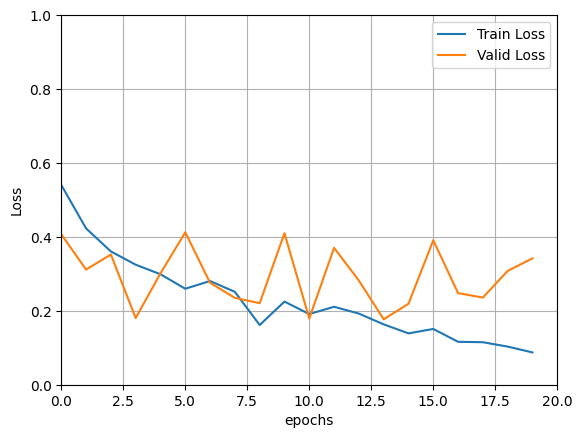

In [24]:
plt.plot( range(history.shape[0]), history["Train Loss"].values, label="Train Loss")
plt.plot( range(history.shape[0]), history["Valid Loss"].values, label="Valid Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.xlim(0, history.shape[0])
plt.ylim(0, 1.0)
plt.grid()
plt.legend()
plt.show()

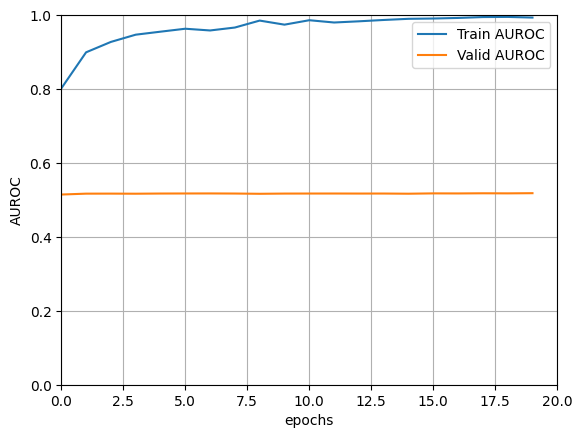

In [25]:
plt.plot( range(history.shape[0]), history["Train AUROC"].values, label="Train AUROC")
plt.plot( range(history.shape[0]), history["Valid AUROC"].values, label="Valid AUROC")
plt.xlabel("epochs")
plt.ylabel("AUROC")
plt.xlim(0, history.shape[0])
plt.ylim(0, 1.0)
plt.grid()
plt.legend()
plt.show()

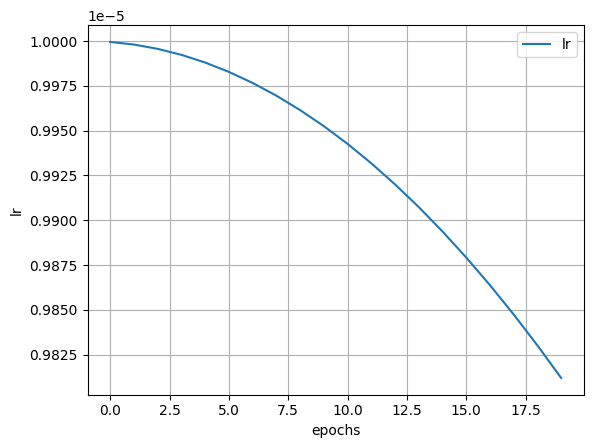

In [26]:
plt.plot( range(history.shape[0]), history["lr"].values, label="lr")
plt.xlabel("epochs")
plt.ylabel("lr")
plt.grid()
plt.legend()
plt.show()

# Metrics

In [27]:
# Validation data
y_preds_valid = []
y_trues_valid = []
with torch.no_grad():
    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    for step, data in bar:        
        images = data['image'].to(CONFIG["device"], dtype=torch.float)
        y_trues_valid.append( data['target'].numpy() )
        batch_size = images.size(0)
        outputs = model(images)
        y_preds_valid.append( outputs.detach().cpu().numpy() )
y_preds_valid = np.concatenate(y_preds_valid).flatten()
y_trues_valid = np.concatenate(y_trues_valid).flatten()

100%|██████████| 26/26 [00:13<00:00,  1.99it/s]


In [28]:
# Training data
del train_loader

df_train = df[df.kfold != fold].reset_index(drop=True)
train_dataset = ISICDataset_for_Train(df_train, HDF_FILE, transforms=data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=2, shuffle=True, pin_memory=True, drop_last=True)

y_preds_train = []
y_trues_train = []
with torch.no_grad():
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, data in bar:        
        images = data['image'].to(CONFIG["device"], dtype=torch.float)
        y_trues_train.append( data['target'].numpy() )
        batch_size = images.size(0)
        outputs = model(images)
        y_preds_train.append( outputs.detach().cpu().numpy() )
y_preds_train = np.concatenate(y_preds_train).flatten()
y_trues_train = np.concatenate(y_trues_train).flatten()

100%|██████████| 19/19 [00:04<00:00,  3.81it/s]


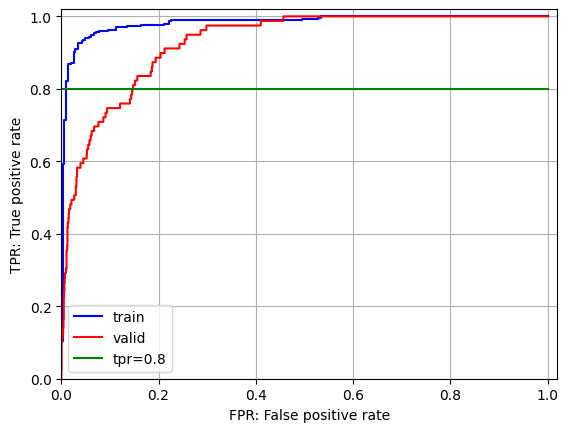

In [29]:
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_trues_valid, y_preds_valid, drop_intermediate=False)
fpr_train, tpr_train, thresholds_train = roc_curve(y_trues_train, y_preds_train, drop_intermediate=False)
plt.plot(fpr_train, tpr_train, color="blue", label="train")
plt.plot(fpr_valid, tpr_valid, color="red", label="valid")
plt.plot([0, 1], [0.8, 0.8], color="green", label="tpr=0.8")
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.xlim(0, 1.02)
plt.ylim(0, 1.02)
plt.grid()
plt.legend()
plt.show()